In [252]:
# Imports
import os
import matplotlib.pyplot as plt
from torch import nn
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, random_split


In [253]:
# Define nn model
class BasicMNISTClassifer(nn.Module):
    def __init__(self):
        super(BasicMNISTClassifer, self).__init__()

        # Layer 1
        self.layer1 = nn.Linear(28*28, 128)
        self.activation1 = nn.ReLU()

        # Layer 2
        self.layer2 = nn.Linear(128, 256)
        self.activation2 = nn.ReLU()

        # Layer 3
        self.layer3 = nn.Linear(256, 10)
        
        # Output layer
        self.output = nn.LogSoftmax(dim=1)
        self.out = []
    
    def forward(self, x):
        batch_size, channels, width, height = x.shape
        # flatten all dims except batch
        x = x.view(batch_size, -1)
        
        # Move input through layers
        for module in self.modules():
            # First module is a reference to the model
            if module == self:
                continue
            x = module(x)
        return x

In [254]:
# Explore strucure of model
model = BasicMNISTClassifer()
dir(model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_se

In [255]:
model.state_dict().keys()

odict_keys(['layer1.weight', 'layer1.bias', 'layer2.weight', 'layer2.bias', 'layer3.weight', 'layer3.bias'])

In [256]:
modules = [module for module in  model.modules()]
type(modules[1])

torch.nn.modules.linear.Linear

In [257]:
parameters = [param for param in model.parameters()]
parameters[0]

Parameter containing:
tensor([[ 0.0190,  0.0040, -0.0188,  ...,  0.0314, -0.0131, -0.0179],
        [ 0.0140,  0.0025, -0.0051,  ..., -0.0037, -0.0300, -0.0327],
        [-0.0131, -0.0272, -0.0098,  ...,  0.0203,  0.0323, -0.0188],
        ...,
        [ 0.0237, -0.0052, -0.0355,  ..., -0.0033, -0.0086,  0.0291],
        [ 0.0309,  0.0115, -0.0316,  ...,  0.0271, -0.0132, -0.0063],
        [-0.0157, -0.0230, -0.0113,  ..., -0.0217, -0.0295, -0.0246]],
       requires_grad=True)

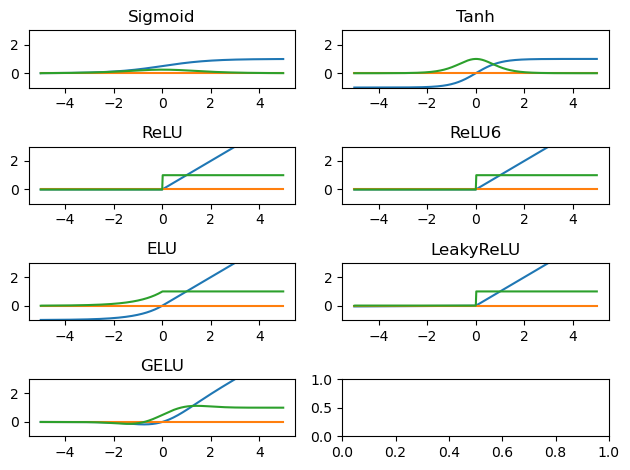

In [258]:
# Explore activations
activations = [
    'Sigmoid',
    'Tanh',
    'ReLU',
    'ReLU6',
    'ELU',
    'LeakyReLU',
    'GELU'
]

# Create subplots
cols = 2
rows = len(activations)//cols + 1
fig, axes = plt.subplots(rows, cols)


# Iterate over activation functions
x_step = 0.02
# x = torch.linspace(-5, 5, 100)
x = torch.arange(-5, 5, x_step)
for num, activation in enumerate(activations):
    fnc = getattr(nn, activation)()
    y = fnc(x)
    ax = axes[divmod(num, cols)]
    ax.plot(x, y)
    ax.plot(x, x*0)
    ax.set_title(activation)
    ax.set_ylim(-1.0, 3.0)
    # numerical grad
    dy = torch.hstack((torch.zeros((1)), torch.diff(y)/x_step))
    ax.plot(x, dy)
    fig.tight_layout()
# fig.subplots_adjust(hspace=0.3, vspace=0.3)

In [259]:
# Load, transform, and split data
# Load data
batch_size = 32
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Training data
train_data = MNIST(os.getcwd(), train=True, download=True, transform=transform)
train_data, val_data = random_split(train_data, [0.9, 0.1])
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

# Testing data
test_data = MNIST(os.getcwd(), train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [260]:
# Recovers original dataset of images
train_data.dataset.data.shape

torch.Size([60000, 28, 28])

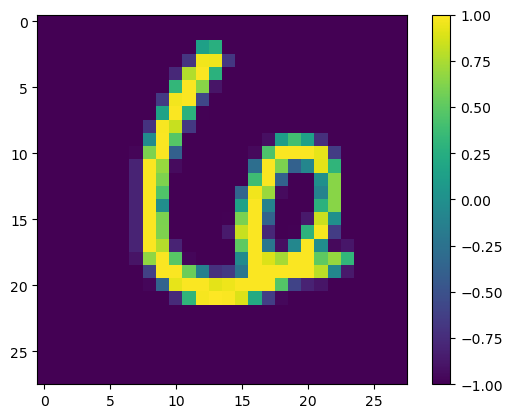

In [261]:
# Explore images returned by dataloader iterator
# Each item returns list of two objects
# 1st object is tensor of batched images
# 2nd object is tensor of indices selected for batch
# batch tensor has shape of (batch_size, channels, width, height)
for itm in val_loader:
    plt.imshow((itm[0][0,0,:,:]))
    plt.colorbar()
    break

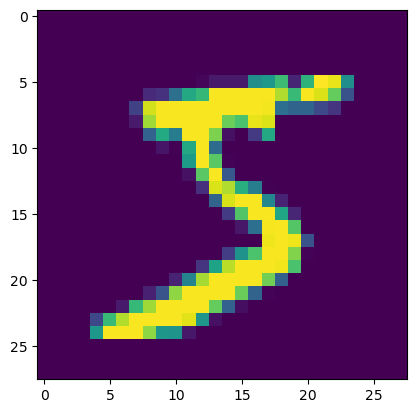

In [262]:
# Explore some example images from the dataset
data_index = 0
img_sample = train_data.dataset.data[data_index]
plt.imshow(img_sample)

In [266]:
# Training and validation
loss_fnc = torch.nn.functional.nll_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(model.parameters, lr=1e-3)

num_epochs = 100
for epoch in epochs:

    # Training
    train_loss = []
    for batch in train_loader:
        # Forward batch
        x, y = batch
        logits = model(x)
        loss = loss_fnc(logits, y)
        train_loss.append(loss)

        # Backprop and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Validation
    val_loss = []
    for batch in val_loader:
        # Forward batch
        x, y = batch
        logits = model(x)
        loss = loss_fnc(logits, y)
        val_loss.append(loss)
        val_loss = torch.mean(torch.tensor(val_loss))

        # Backprop and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        val_loss = torch.mean(torch.tensor(val_loss))

    # 



TypeError: 'method' object is not iterable